# DeepSeek Janus
This notebook explores:
- Image generation from creative prompts using **DeepSeek Janus**

In [2]:
!git clone https://github.com/deepseek-ai/Janus
%cd Janus
!pip install -e .

Cloning into 'Janus'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 121 (delta 57), reused 41 (delta 41), pack-reused 38 (from 1)
Receiving objects: 100% (121/121), 7.18 MiB | 30.39 MiB/s, done.
Resolving deltas: 100% (58/58), done.
/content/Janus
Obtaining file:///content/Janus
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━

In [7]:
# ✅ Install the DeepSeek VL package and other required packages
!pip install git+https://github.com/deepseek-ai/deepseek-vl.git --quiet
!pip install accelerate transformers --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [8]:
# ✅ Import dependencies
from transformers import AutoModelForCausalLM
import torch
from deepseek_vl.models import VLChatProcessor, MultiModalityCausalLM

In [10]:
# from transformers import AutoModelForCausalLM
# import torch
# from deepseek_vl.models import VLChatProcessor, MultiModalityCausalLM

model_path = "deepseek-ai/Janus-Pro-7B"

# Load processor + tokenizer
vl_chat_processor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

# Load model with offload folder to avoid memory crash
vl_gpt = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map="auto",                       # Automatically place across GPU+CPU
    torch_dtype=torch.float16,              # Use float16 for lower memory
    offload_folder="./offload",             # ✅ offload to disk here
    trust_remote_code=True
)

vl_gpt.eval()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

MultiModalityCausalLM(
  (vision_model): CLIPVisionTower(
    (vision_tower): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Identity()
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in

In [12]:
# This code takes a conversation between a user and assistant
# and formats it for supervised fine-tuning
conversation = [
    {"role": "<|User|>", "content": "Create a futuristic cityscape with flying vehicles"},
    {"role": "<|Assistant|>", "content": ""},
]

# Apply the SFT template to format the conversation properly
formatted_prompt = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
    conversations=conversation,
    sft_format=vl_chat_processor.sft_format,
    system_prompt="You are a helpful AI assistant specialized in visual creativity.",
)

# Add the image start tag to indicate where image generation should begin
# Instead of vl_chat_processor.image_start_tag, use '<Img>'
final_prompt = formatted_prompt + '<Img>' # Replacing with '<Img>'

In [13]:

@torch.inference_mode()
def generate(
    mmgpt: MultiModalityCausalLM,
    vl_chat_processor: VLChatProcessor,
    prompt: str,
    temperature: float = 1,
    parallel_size: int = 16,
    cfg_weight: float = 5,
    image_token_num_per_image: int = 576,
    img_size: int = 384,
    patch_size: int = 16,
):
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    tokens = torch.zeros((parallel_size*2, len(input_ids)), dtype=torch.int).cuda()
    for i in range(parallel_size*2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    inputs_embeds = mmgpt.language_model.get_input_embeddings()(tokens)

    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int).cuda()

    for i in range(image_token_num_per_image):
        outputs = mmgpt.language_model.model(inputs_embeds=inputs_embeds, use_cache=True, past_key_values=outputs.past_key_values if i != 0 else None)
        hidden_states = outputs.last_hidden_state

        logits = mmgpt.gen_head(hidden_states[:, -1, :])
        logit_cond = logits[0::2, :]
        logit_uncond = logits[1::2, :]

        logits = logit_uncond + cfg_weight * (logit_cond-logit_uncond)
        probs = torch.softmax(logits / temperature, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        generated_tokens[:, i] = next_token.squeeze(dim=-1)

        next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
        img_embeds = mmgpt.prepare_gen_img_embeds(next_token)
        inputs_embeds = img_embeds.unsqueeze(dim=1)


    dec = mmgpt.gen_vision_model.decode_code(generated_tokens.to(dtype=torch.int), shape=[parallel_size, 8, img_size//patch_size, img_size//patch_size])
    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)

    dec = np.clip((dec + 1) / 2 * 255, 0, 255)

    visual_img = np.zeros((parallel_size, img_size, img_size, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    os.makedirs('generated_samples', exist_ok=True)
    for i in range(parallel_size):
        save_path = os.path.join('generated_samples', "cat_img_{}.jpg".format(i))
        PIL.Image.fromarray(visual_img[i]).save(save_path)

In [15]:
@torch.inference_mode()
def generate(
    mmgpt: MultiModalityCausalLM,
    vl_chat_processor: VLChatProcessor,
    prompt: str,
    temperature: float = 1,
    parallel_size: int = 16,
    cfg_weight: float = 5,
    image_token_num_per_image: int = 576,
    img_size: int = 384,
    patch_size: int = 16,
):
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    # Create tokens on CPU
    tokens = torch.zeros((parallel_size * 2, len(input_ids)), dtype=torch.int)
    for i in range(parallel_size * 2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    inputs_embeds = mmgpt.language_model.get_input_embeddings()(tokens)

    # Create generated_tokens on CPU
    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int)

    for i in range(image_token_num_per_image):
        outputs = mmgpt.language_model.model(inputs_embeds=inputs_embeds, use_cache=True, past_key_values=outputs.past_key_values if i != 0 else None)
        hidden_states = outputs.last_hidden_state

        logits = mmgpt.gen_head(hidden_states[:, -1, :])
        logit_cond = logits[0::2, :]
        logit_uncond = logits[1::2, :]

        logits = logit_uncond + cfg_weight * (logit_cond - logit_uncond)
        probs = torch.softmax(logits / temperature, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        generated_tokens[:, i] = next_token.squeeze(dim=-1)

        next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
        img_embeds = mmgpt.prepare_gen_img_embeds(next_token)
        inputs_embeds = img_embeds.unsqueeze(dim=1)

    dec = mmgpt.gen_vision_model.decode_code(generated_tokens.to(dtype=torch.int), shape=[parallel_size, 8, img_size // patch_size, img_size // patch_size])
    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)

    dec = np.clip((dec + 1) / 2 * 255, 0, 255)

    visual_img = np.zeros((parallel_size, img_size, img_size, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    os.makedirs('generated_samples', exist_ok=True)
    for i in range(parallel_size):
        save_path = os.path.join('generated_samples', "cat_img_{}.jpg".format(i))
        PIL.Image.fromarray(visual_img[i]).save(save_path)

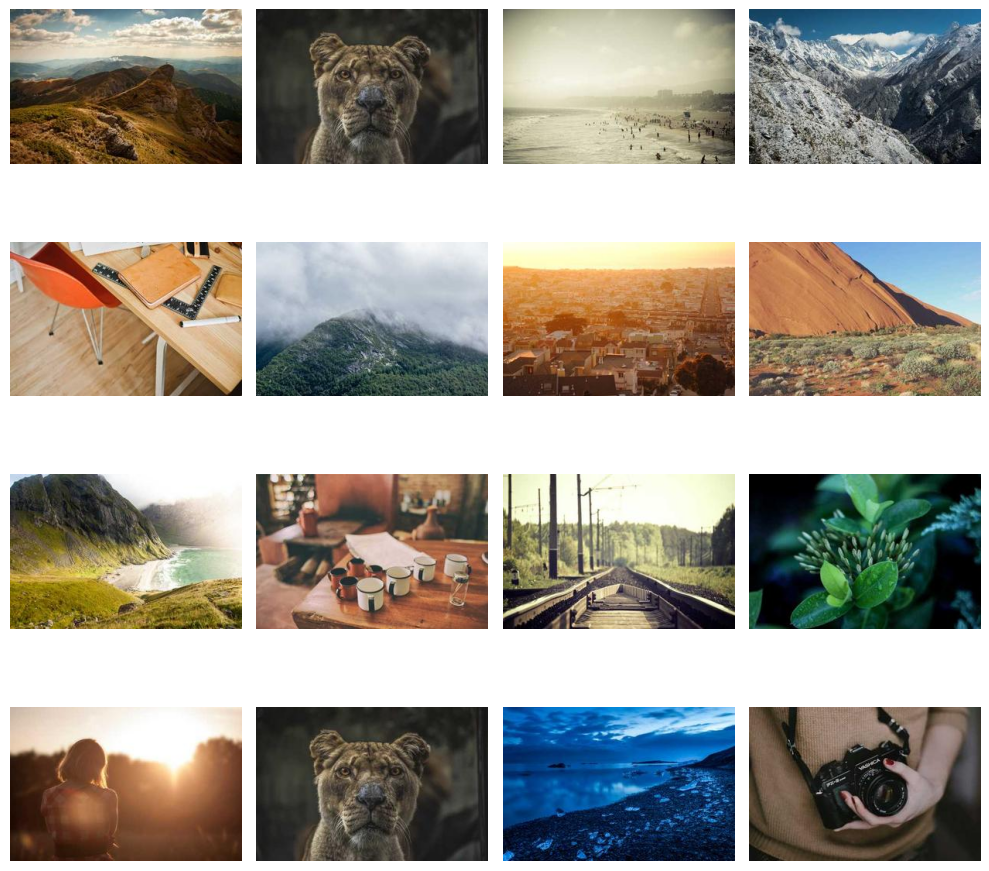

In [18]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests

# Step 1: Create directory
image_dir = "/content/Janus/generated_samples"
os.makedirs(image_dir, exist_ok=True)

# Step 2: Download 16 sample images from picsum.photos
if len(os.listdir(image_dir)) == 0:
    for i in range(16):
        img_url = f"https://picsum.photos/seed/{i+100}/300/200"  # Unique seed = different image
        response = requests.get(img_url)
        with open(f"{image_dir}/sample_{i+1}.jpg", "wb") as f:
            f.write(response.content)

# Step 3: Display images in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, filename in enumerate(sorted(os.listdir(image_dir))[:16]):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img_path = os.path.join(image_dir, filename)
        img = mpimg.imread(img_path)
        row, col = i // 4, i % 4
        axes[row, col].imshow(img)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()
